# Seasonal decomposition
Example usage of the seasonal decomposition function
## Overview
A function within the Process_data class that will decompose time series into trend, seasonal and residual components. The function is a wrapper that adds functionality to the `seasonal_decompose` function contained in the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose) package to make it more convenient for large geospatial datasets.

Specifically:
1) Multiple time series spread across multiple dimensions, e.g. a gridded dataset, can be processed. The user simply passes in an xarray DataArray that has a "t_dim" dimension and 1 or more additional dimensions, for example gridded spatial dimensions
2) Masked locations, such as land points, are handled
3) A [dask](https://www.dask.org/) wrapper is applied to the function that 
    a) supports lazy evaluation
    b) allows the dataset to be easily seperated into chunks so that processing can be carried out in parallel (rather than processing every time series sequentially)
4) The decomposed time series are returned as xarray DataArrays within a single coast.Gridded object

## An example
Below is an example using the `coast.Process_data.seasonal_decomposition` function with the example data. Note that we will artifically extend the length of the example data time series for demonstrative purposes.

Begin by importing coast, defining paths to the data, and loading the example data into a gridded object:

In [1]:
import coast
import numpy as np
import xarray as xr

# Path to a data file.
fn_nemo_dat  = "./example_files/coast_example_nemo_data.nc"
# Set path for domain file if required.
fn_nemo_dom  = "./example_files/coast_example_nemo_domain.nc"
# Set path for model configuration file
config = "./config/example_nemo_grid_t.json"

# Read in data (This example uses NEMO data.)
grd = coast.Gridded(fn_nemo_dat, fn_nemo_dom, config=config)

The loaded example data only has 7 time stamps, the code below creates a new (fake) extended temperature variable with 48 monthly records. This code is not required to use the function, it is only included here to make a set of time series that are long enough to be interesting.

In [3]:
# create a 4 yr monthly time coordinate array
time_array = np.arange(
    np.datetime64("2010-01-01"), np.datetime64("2014-01-01"), np.timedelta64(1, "M"), dtype="datetime64[M]"
).astype("datetime64[s]")

# create 4 years of monthly temperature data based on the loaded data
temperature_array = (
    (np.arange(0, 48) * 0.05)[:, np.newaxis, np.newaxis, np.newaxis]
    + np.random.normal(0, 0.1, 48)[:, np.newaxis, np.newaxis, np.newaxis]
    + np.tile(grd.dataset.temperature[:-1, :2, :, :], (8, 1, 1, 1))
)

# create a new temperature DataArray
temperature = xr.DataArray(
    temperature_array,
    coords={
        "t_dim": time_array,
        "depth_0": grd.dataset.depth_0[:2, :, :],
        "longitude": grd.dataset.longitude,
        "latitude": grd.dataset.latitude,
    },
    dims=["t_dim", "z_dim", "y_dim", "x_dim"],
)

Check out the new data

In [8]:
temperature

<xarray.DataArray (t_dim: 48, z_dim: 2, y_dim: 375, x_dim: 297)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan, 15.41602644, 15.32911238, ...,         nan,
                  nan,         nan],
         [        nan, 15.43067488, 15.82813581, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan, 15.40430769, 15.31739363, ...,         nan,
                  nan,         nan],
         [        nan, 15.41895613, 15.82813581, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan, 17.23080518, 17.24447705, ...,         nan,
                  nan,         nan],
         [        nan, 17.2093208 , 17.03353955, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * t_dim      (t_dim) datetime64[ns] 2010-01-01 2010-02-01 ... 2013-12-01
    depth_0    (z_dim, y_dim, x_dim) float32 0.5 0.5 0.5 0.5 ... 1.5 1.5 1.5 1.5
    longitude  (y_dim, x_dim) float32 ...
    latitude   (y_dim, x_dim) float32 ...
Dimensions without coordinates: z_dim, y_dim, x_dim

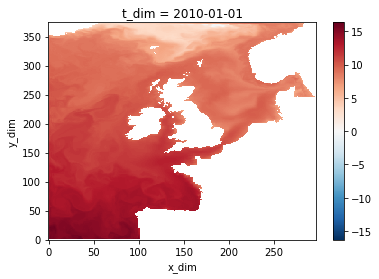

In [9]:
temperature[0,0,:,:].plot()

Check out time series at 2 different grid points

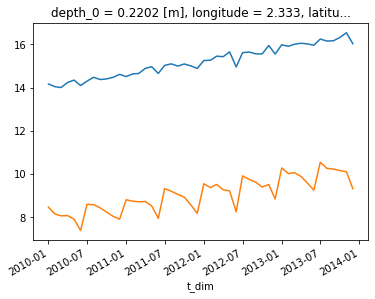

In [11]:
temperature[:,0,50,50].plot()
temperature[:,0,200,200].plot()

Create a `coast.Process_data` object, and call the `seasonal_decomposition` function, passing in the required arguments. The first two arguments are:
1. The input data, here the temperature data as an xarray DataArray
2. The number of chuncks to split the data into. Here we split the data into 2 chunks so that the dask scheduler will try to run 4 processes in parallel

The remaining arguments are keyword arguments for the underlying `statsmodels.tsa.seasonal.seasonal_decompose` function, which are documented on the [statsmodels documentation pages](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose).  Here we specify:

3. three The type of model, i.e. an additive model
4. The period of the seasonal cycle, here it is 6 months
5. Extrapolate the trend component to cover the entire range of the time series (this is required because the trend is calculated using a convolution filter) 


In [12]:
proc_data = coast.Process_data()
grd = proc_data.seasonal_decomposition(temperature, 2, model="additive", period=6, extrapolate_trend="freq")

The returned xarray Dataset contains the decomposed time series (trend, seasonal, residual) as dask arrays

In [13]:
grd.dataset

<xarray.Dataset>
Dimensions:    (t_dim: 48, z_dim: 2, y_dim: 375, x_dim: 297)
Coordinates:
  * t_dim      (t_dim) datetime64[ns] 2010-01-01 2010-02-01 ... 2013-12-01
    depth_0    (z_dim, y_dim, x_dim) float32 dask.array<chunksize=(1, 375, 297), meta=np.ndarray>
    longitude  (y_dim, x_dim) float32 dask.array<chunksize=(375, 297), meta=np.ndarray>
    latitude   (y_dim, x_dim) float32 dask.array<chunksize=(375, 297), meta=np.ndarray>
Dimensions without coordinates: z_dim, y_dim, x_dim
Data variables:
    trend      (t_dim, z_dim, y_dim, x_dim) float64 dask.array<chunksize=(48, 1, 375, 297), meta=np.ndarray>
    seasonal   (t_dim, z_dim, y_dim, x_dim) float64 dask.array<chunksize=(48, 1, 375, 297), meta=np.ndarray>
    residual   (t_dim, z_dim, y_dim, x_dim) float64 dask.array<chunksize=(48, 1, 375, 297), meta=np.ndarray>

Execute the computation

In [14]:
grd.dataset.compute()

<xarray.Dataset>
Dimensions:    (t_dim: 48, z_dim: 2, y_dim: 375, x_dim: 297)
Coordinates:
  * t_dim      (t_dim) datetime64[ns] 2010-01-01 2010-02-01 ... 2013-12-01
    depth_0    (z_dim, y_dim, x_dim) float32 0.5 0.5 0.5 0.5 ... 1.5 1.5 1.5 1.5
    longitude  (y_dim, x_dim) float32 -19.89 -19.78 -19.67 ... 12.78 12.89 13.0
    latitude   (y_dim, x_dim) float32 40.07 40.07 40.07 40.07 ... 65.0 65.0 65.0
Dimensions without coordinates: z_dim, y_dim, x_dim
Data variables:
    trend      (t_dim, z_dim, y_dim, x_dim) float64 nan nan nan ... nan nan nan
    seasonal   (t_dim, z_dim, y_dim, x_dim) float64 nan nan nan ... nan nan nan
    residual   (t_dim, z_dim, y_dim, x_dim) float64 nan nan nan ... nan nan nan

Plot the decomposed time series

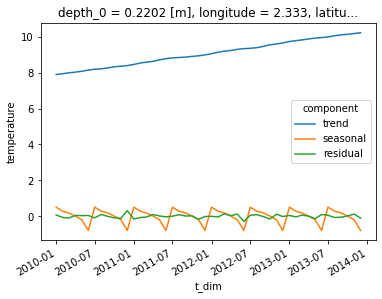

In [15]:
component = xr.DataArray( ["trend","seasonal","residual"], dims="component", name="component" )
temp_decomp = xr.concat( 
    [grd.dataset.trend, grd.dataset.seasonal,grd.dataset.residual], dim=component 
)
temp_decomp.name = "temperature"
temp_decomp[:,:,0,200,200].plot(hue="component")